In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

#plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import folium


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nypd-motor-vehicle-collisions/nypd-motor-vehicle-collisions.csv
/kaggle/input/nypd-motor-vehicle-collisions/socrata_metadata.json
/kaggle/input/nypd-motor-vehicle-collisions/MVCollisionsDataDictionary_20190813_ERD.xlsx


In [2]:
#get the data
df = pd.read_csv('../input/nypd-motor-vehicle-collisions/nypd-motor-vehicle-collisions.csv', dtype=str)

In [3]:
#sohw dataframe
df.head(3)

,ACCIDENT DATE,ACCIDENT TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2019-08-05T00:00:00.000,16:30,QUEENS,11434,40.6760520,-73.7901840,"{'type': 'Point', 'coordinates': [-73.790184, ...",NaN,NaN,150-08 123 AVENUE,...,Unspecified,NaN,NaN,NaN,4184637,Sedan,Pick-up Truck,NaN,NaN,NaN
1,2019-08-27T00:00:00.000,16:02,BROOKLYN,11225,40.6577800,-73.9510960,"{'type': 'Point', 'coordinates': [-73.951096, ...",NaN,NaN,288 HAWTHORNE STREET,...,Unspecified,NaN,NaN,NaN,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,2019-08-15T00:00:00.000,17:57,MANHATTAN,10002,40.7181430,-73.9938350,"{'type': 'Point', 'coordinates': [-73.993835, ...",CHRYSTIE STREET,GRAND STREET,NaN,...,NaN,NaN,NaN,NaN,4202457,Sedan,NaN,NaN,NaN,NaN


In [4]:
#dataset shape
print('DATASET SHAPE: ', df.shape)

DATASET SHAPE:  (1612178, 29)


In [5]:
#show feature data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612178 entries, 0 to 1612177
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   ACCIDENT DATE                  1612178 non-null  object
 1   ACCIDENT TIME                  1612178 non-null  object
 2   BOROUGH                        1127553 non-null  object
 3   ZIP CODE                       1127376 non-null  object
 4   LATITUDE                       1415893 non-null  object
 5   LONGITUDE                      1415893 non-null  object
 6   LOCATION                       1415893 non-null  object
 7   ON STREET NAME                 1298002 non-null  object
 8   CROSS STREET NAME              1079193 non-null  object
 9   OFF STREET NAME                219732 non-null   object
 10  NUMBER OF PERSONS INJURED      1612161 non-null  object
 11  NUMBER OF PERSONS KILLED       1612145 non-null  object
 12  NUMBER OF PEDESTRIANS INJURE

In [6]:
#replace capslock to lowercase
df.columns = [i.lower() for i in df.columns]
#date to pandas datetime object
df['accident date'] = pd.to_datetime(df['accident date'])
df['accident time'] = pd.to_datetime(df['accident time']).dt.time

In [7]:
#convert back the numeric features
num_feat = [i for i in df.columns if 'number' in i] + ['latitude', 'longitude']
df[num_feat] = df[num_feat].apply(pd.to_numeric, errors='coerce')

#### CHECK NULL VALUES

In [8]:
#show null value percentage per feature
pd.DataFrame(df.isnull().sum() / df.shape[0] *100, columns=['Missing Value %'])

,Missing Value %
accident date,0.000000
accident time,0.000000
borough,30.060266
zip code,30.071245
latitude,12.175144
longitude,12.175144
location,12.175144
on street name,19.487674
cross street name,33.059935
off street name,86.370488


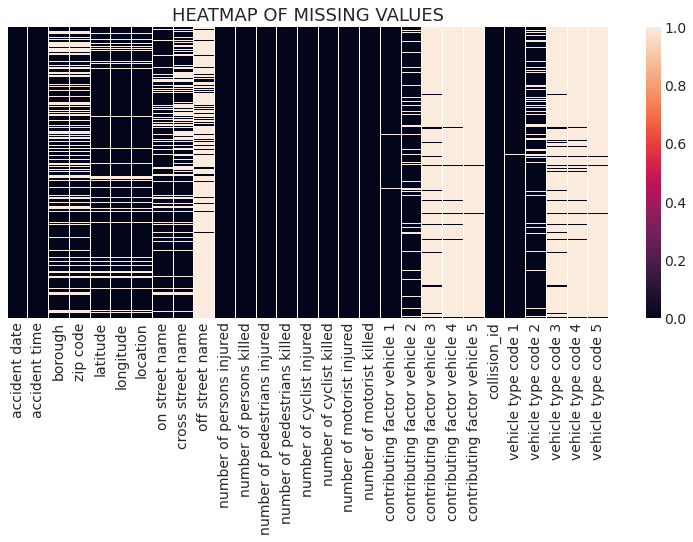

In [9]:
plt.figure(figsize=(12,5))
plt.title('HEATMAP OF MISSING VALUES', fontsize=18)
sns.heatmap(df.isnull(), yticklabels=False)

## EDA
---

### ANALYSIS BY BOROUGH

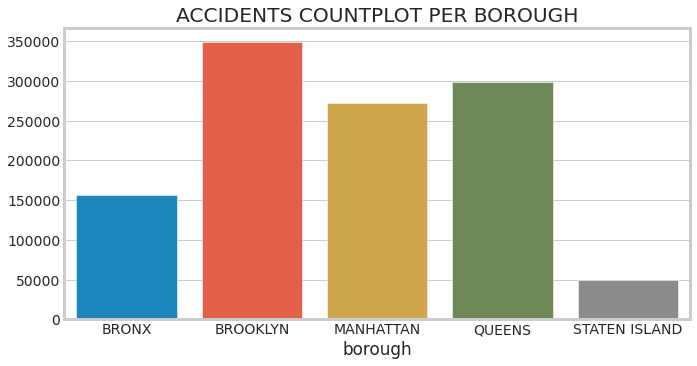

In [10]:
plt.figure(figsize=(10,5))
plt.title('ACCIDENTS COUNTPLOT PER BOROUGH')
sns.barplot(x=df.groupby('borough').size().index,
            y=df.groupby('borough').size().values)

### INSIGHTS
---
* ROAD ACCIDENTS ARE MORE FREQUENT IN BROOKLYN, MANHATTAN AND QUEENS
* STATEN ISLAND HAS THE LOWEST ACCIDENT RATE

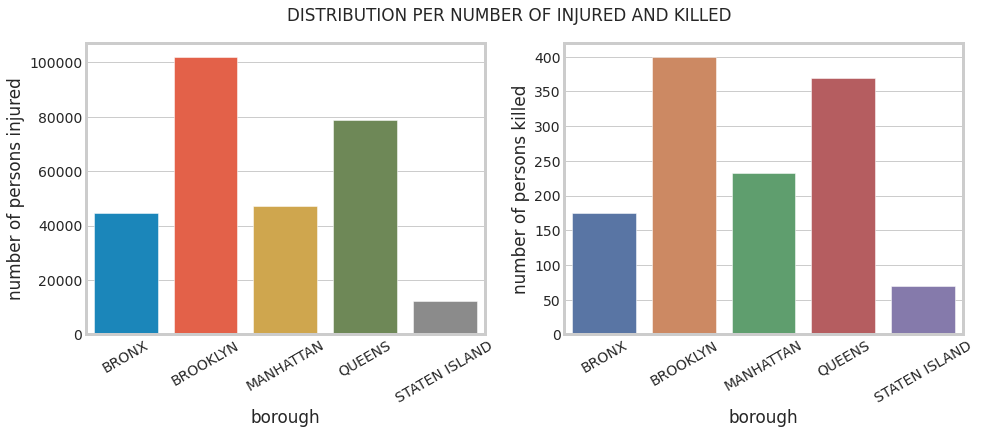

In [11]:
accidents_bor_df = df.groupby('borough')[['number of persons injured', 'number of persons killed']].sum()


fig, ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('DISTRIBUTION PER NUMBER OF INJURED AND KILLED')

ax[1].set_xticklabels(labels=accidents_bor_df.index,rotation=30)
ax[0].set_xticklabels(labels=accidents_bor_df.index,rotation=30)


sns.barplot(accidents_bor_df.index, accidents_bor_df['number of persons injured'], ax=ax[0])
sns.barplot(accidents_bor_df.index, accidents_bor_df['number of persons killed'], ax=ax[1], palette='deep')



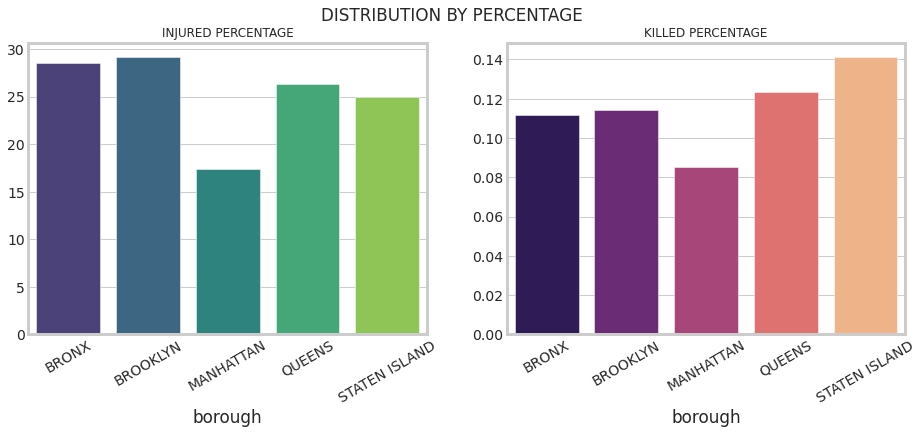

In [12]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
plt.suptitle('DISTRIBUTION BY PERCENTAGE')

ax[1].set_xticklabels(labels=accidents_bor_df.index,rotation=30)
ax[0].set_xticklabels(labels=accidents_bor_df.index,rotation=30)
ax[0].set_title('INJURED PERCENTAGE', fontsize=12)
ax[1].set_title('KILLED PERCENTAGE', fontsize=12)


sns.barplot((accidents_bor_df['number of persons injured'] / df.groupby('borough').size() *100).index, 
           (accidents_bor_df['number of persons injured'] / df.groupby('borough').size() *100).values, ax=ax[0], palette='viridis')

sns.barplot((accidents_bor_df['number of persons killed'] / df.groupby('borough').size() *100).index, 
           (accidents_bor_df['number of persons killed'] / df.groupby('borough').size() *100).values, ax=ax[1], palette='magma')

In [13]:
print('MEAN INJURED: ',(accidents_bor_df['number of persons injured'] / df.groupby('borough').size() *100).values.mean())
print('MEAN KILLED: ',(accidents_bor_df['number of persons killed'] / df.groupby('borough').size() *100).values.mean())

MEAN INJURED:  25.258721101545422
MEAN KILLED:  0.1151597454148819


### INSIGHTS
---
* From the information above, There is a 25% chance that you will get injured if you get into an road accident.
* Probability of getting killed on an accident is low.

### DATEWISE ANALYSIS

In [26]:
datewise = df.groupby(['accident date', 'borough'])[[i for i in df.columns if 'number' in i]].sum()

In [81]:
fig = make_subplots(rows=2,cols=1, 
                    subplot_titles=('NUMBER OF INJURED PER DAY', 'NUMBER OF KILLED PER DAY'))
cols = ['QUEENS', 'BROOKLYN', 'MANHATTAN', 'BRONX', 'STATEN ISLAND']
feat  = [i for i in df.columns if 'number' in i] + ['accident date']

for i, bor in enumerate(cols):
    data_per_bor = df[df['borough']== bor][feat]
    data_per_bor = data_per_bor.groupby('accident date').sum()
    
    fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['number of persons injured'], name=bor), row=1,col=1)
    fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['number of persons killed'], name=bor), row=2, col=1)

fig.update_layout(template='plotly_dark', width=1000, height=800)
fig.show()

#### SNIPPET OF NUMBER ACCIDENTS (LAST 365 DAYS)

In [80]:
fig = make_subplots(rows=2,cols=1, 
                    subplot_titles=('NUMBER OF INJURED PER DAY', 'NUMBER OF KILLED PER DAY'))
cols = ['QUEENS', 'BROOKLYN', 'MANHATTAN', 'BRONX', 'STATEN ISLAND']
feat  = [i for i in df.columns if 'number' in i] + ['accident date']

for i, bor in enumerate(cols):
    data_per_bor = df[df['borough']== bor][feat]
    data_per_bor = data_per_bor.groupby('accident date').sum()[-365:]
    
    fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['number of persons injured'], name=bor), row=1,col=1)
    fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['number of persons killed'], name=bor), row=2, col=1)

fig.update_layout(template='plotly_dark', width=1000, height=800)
fig.show()

### INSIGHTS
---
* As we can see from the plot above, the highest number of people killed per day on a car accident is 8, which was October october 2017, a terror attack that also injured 11 people.